# Reviews analysis on European Luxury Hotels

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import geoviews as gv
import geoviews.tile_sources as gvts
import hvplot.pandas
import holoviews as hv
import seaborn as sns
import altair as alt

np.random.seed(42)

palette5 = ["#61a262","#1a7328","#f2b4ae","#f26a4b","#f25d50"]
palette4 = ["#61a262","#1a7328","#f2b4ae","#f25d50"]
palette2 = ["#61a262","#f26a4b"]


In [2]:
# set Kaggle key to environment variable
os.environ["KAGGLE_USERNAME"] = "lanxiao1120"
os.environ["KAGGLE_KEY"] = "dc6f594f7f5b866e3aec880f88948cb8"

# !!users need to install kaggle package first
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [3]:
#Signature: dataset_download_file(dataset, file_name, path=None, force=False, quiet=True)
# download file via API
api.dataset_download_file('jiashenliu/515k-hotel-reviews-data-in-europe','Hotel_Reviews.csv', path='data')
# read it
hotel_raw = pd.read_csv('data/Hotel_Reviews.csv.zip')

#hotel_raw.head()

In [4]:
# set up coord
hotel = hotel_raw.copy()
hotel['geometry'] = gpd.points_from_xy(hotel['lng'], hotel['lat'])

# to geo df
hotel = gpd.GeoDataFrame(hotel, geometry="geometry", crs="EPSG:4326")

# convert crs to 3857
hotel = hotel.to_crs(epsg=3857)

# transform to date
hotel['Review_Date'] = pd.to_datetime(hotel['Review_Date'] ,format='%m/%d/%Y')

# trim into 2016
hotel = hotel.loc[hotel['Review_Date'] >= '2016-01-01']
hotel = hotel.loc[hotel['Review_Date'] < '2017-01-01']


In [5]:
%%opts WMTS [width=800, height=800, xaxis=None, yaxis=None]

hotel_2017 = hotel.loc[hotel['Review_Date']>'2017-01-01']

#hotel_2017.hvplot(geo=True, tiles=True, crs=3857)

In [6]:
# get country data 
url = 'https://gisco-services.ec.europa.eu/distribution/v2/countries/geojson/CNTR_RG_01M_2020_3857.geojson'
country = gpd.read_file(url)
#select col
country = country[['NAME_ENGL','geometry']]
# spatial join
hotel_joined = gpd.sjoin(hotel, country, op='within', how='left').drop(['index_right'], axis=1)


In [7]:
# change column name
hotel_joined = hotel_joined.rename(
    columns={"NAME_ENGL": "Country"}
)



In [8]:
hotel_review = hotel_joined.copy()

hotel_review['Negative_Review'] = [review.lower().split() for review in hotel_review['Negative_Review']]
hotel_review['Positive_Review'] = [review.lower().split() for review in hotel_review['Positive_Review']]

Load common punctuation and create a list.

In [9]:
import nltk
# download stop words
nltk.download('stopwords');

#Get the list of common stop words
stop_words = list(set(nltk.corpus.stopwords.words('english')))

[nltk_data] Downloading package stopwords to /Users/lexi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import string

punctuation = list(string.punctuation)

In [11]:
# list to remove
ignored = stop_words + punctuation

# Remove from each review column
hotel_review['Negative_Review'] = [[word for word in review if word not in ignored]
              for review in hotel_review['Negative_Review']]
hotel_review['Positive_Review'] = [[word for word in review if word not in ignored]
              for review in hotel_review['Positive_Review']]

In [12]:
hotel_review['Total_Review'] = pd.concat([hotel_review['Negative_Review'],hotel_review['Positive_Review']], 
                                         ignore_index=True)

hotel_review.head(n=2)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,geometry,Country,Total_Review
66,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2016-12-29,7.7,Hotel Arena,United Kingdom,"[asked, coffee, sugars, got, given, two, satch...",40,1403,"[nice, open, room, bed, plenty, room, bath, ro...",28,7,9.2,"[' Leisure trip ', ' Couple ', ' Large King Ro...",217 day,52.360576,4.915968,POINT (547243.088 6865586.634),Netherlands,"[would, nice, one, responsible, cleaning, room..."
67,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2016-12-28,7.7,Hotel Arena,South Africa,"[room, cleaned, correctly, wine, champagne, gl...",30,1403,"[begin, upgraded, made, wife, happy, room, spa...",92,6,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",218 day,52.360576,4.915968,POINT (547243.088 6865586.634),Netherlands,"[first, impressions, dark, reception, made, us..."


In [13]:
def count_word(review_col, top=20):
    """
    Given a column of all words for every rhotel, count word frequencies across all reviews.
    
    By default, this returns the top 20 words, but you can specify a different value for `top`.
    """
    import itertools, collections
    
    # List of all words across hotels
    all_words = list(itertools.chain(*review_col))

    # Create counter
    counter = collections.Counter(all_words)
    
    return pd.DataFrame(counter.most_common(top),
                        columns=['words', 'count'])

In [14]:
counts_reviews = count_word(hotel_review['Total_Review'], top=20)


In [15]:
neutral_words = ["nothing", "hotel", "would","could","one","bit","little","us","get","time","really","also","even"]
hotel_review['Total_Review'] = [[word for word in review if word not in neutral_words]
              for review in hotel_review['Total_Review']]

In [16]:
counts_reviews = count_word(hotel_review['Total_Review'], top=20)

In [17]:
import multidict as multidict
import numpy as np
import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools, collections


def getFrequencyDictForText(sentence): 
    
    """
    Given a list of all words from all reviews, count word frequencies across all reviews, 
    return a dictionary of word and frequency.
    
    """

    # get frequency
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

        
def plot_cloud(Country, Maximum=50,df=hotel_review, select_col='Country', text_col='Total_Review', title="Most used words in reviews by country"):
    """
    Given a dataframe, the column to interact with, the column with review text, 
    selected the country to analyze, maxmium word to display, title to show,
    generate a word cloud.
    
    """
        
    # select country 
    df_filtered = df.loc[df[select_col]==Country]
    # put all review words into one string object.
    all_words_list = list(itertools.chain(*df_filtered[text_col]))
    all_words = ''
    for word in all_words_list:
        all_words += " " + word
    
    # load base pic
    #alice_mask = np.array(Image.open("image/europe.png"))

    # set up word clooud
    wc = WordCloud(background_color="white", 
                   max_words=Maximum,
                   width=1500,       
                   height=960,          
                   margin=10)
    
    # generate word cloud
    wc.generate_from_frequencies(getFrequencyDictForText(all_words))
    
    # show
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=40,fontweight="bold")
    plt.figure()
    

In [18]:
list1 = list(hotel_review['Country'].unique())

# remove nan
list1 = list1[0:3]+list1[4:7]

list1

['Netherlands', 'United Kingdom', 'France', 'Spain', 'Austria', 'Italy']

In [19]:
"""
from ipywidgets import widgets, interact, interactive, fixed
import spacy

a = interact(plot_cloud, 
         df=fixed(hotel_review), 
         select_col = fixed('Country'), 
         text_col = fixed('Total_Review'),
         Country = list1, 
         Maximum=[20,50,100,150],
         title = fixed("Most used words in reviews by country"),
        )
"""

interactive(children=(Dropdown(description='Country', options=('Netherlands', 'United Kingdom', 'France', 'Spa…

Row
    [0] Column
        [0] Markdown(str)
        [1] Column
            [0] Select(name='Country', options=['Netherlands', ...], value='Netherlands')
            [1] DiscreteSlider(formatter='%d', name='Maximum', options=[20, 50, 100, 150], value=50)
    [1] Row
        [0] Str(None, name='interactive03799')

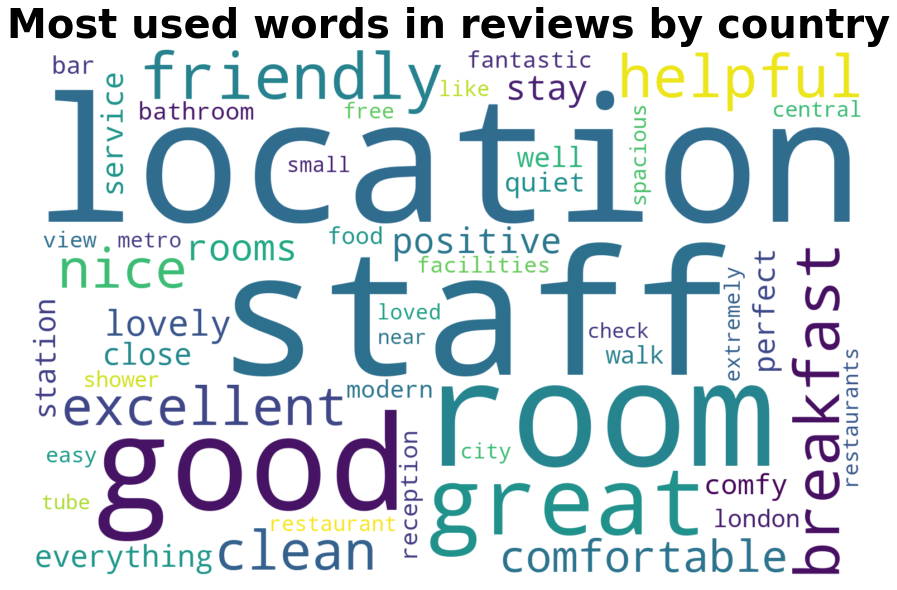

<Figure size 432x288 with 0 Axes>

In [21]:
list2 = [20,50,100,150]
# Load panel and enable interactive features
import panel as pn
pn.extension()
# Auto-generate the layout
layout = pn.interact(plot_cloud, Country=list1, Maximum=list2)

# Create the dashboard with a Row and Column
panel = pn.Row(pn.Column('## MPG Explorer', layout[0]), layout[1])

panel.servable()